In [6452]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
import random

%matplotlib inline
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (18, 4)

In [6453]:
inputdata1 = "../output_qt/combined_qt_data/"
outputdata1 = "../output_qt/regressiondata_qt/"

In [6454]:
def get_data():
    get_data = pd.read_csv(inputdata1 + "a0_combinedQuarterly_extended_ARIMA.csv", index_col=0)
    first_date = get_data.index[0]

    get_data.index = pd.date_range(first_date, get_data.index[-1], freq='QS').date
    return get_data

df = get_data()

In [6455]:

# subset of the data
df1 = df[[
        # 'gdp_total',
        # 'imports_goods_services',
        # 'household_cons',
        # 'gov_consumption', 
        # 'investments', 
        # 'gpd_invest_business_households',
        # 'gov_invest', 
        # 'change_supply', 
        # 'exports_goods_services',
        'gdp_total_deseasonalized', 
        'imports_goods_services_deseasonalized',
        'household_cons_deseasonalized', 
        'gov_consumption_deseasonalized',
        'investments_deseasonalized',
        'gpd_invest_business_households_deseasonalized',
        'gov_invest_deseasonalized', 
        'change_supply_deseasonalized',
        'exports_goods_services_deseasonalized',
        'BeloningSeizoengecorrigeerd_2', 
        'Loonkosten_7',
        'BeloningVanWerknemers_8', 
        'Germany_GDP',
        'France_GDP', 
        'Italy_GDP', 
        'Spain_GDP', 
        'Belgium_GDP' 
        ]]

In [6456]:

#############################
# change name if seasonally adjusted for code consistency
#############################
if(any([col for col in df1.columns if 'gdp_total_deseasonalized' in col])):
    df1.insert(0, 'gdp_total', df1.pop('gdp_total_deseasonalized'))

### Add 'sure' data and random data

In [6457]:

# create a sure-fire predictor
df1['gdp_total_dirty_0'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']
df1['gdp_total_dirty_1'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']

# randos
df1['random_0'] = [random.random() for _ in range(0, len(df1))] 
df1['random_1'] = [random.random() for _ in range(0, len(df1))] 

print(df1.shape)

(119, 21)


### Log and scale data

In [6458]:
# scale data to make comparable

def log_data(data,seasonal_only = True):

    if seasonal_only:
        df2 = np.log(data.loc[:, ~data.columns.isin(['change_supply_deseasonalized'])])
        df2['change_supply_deseasonalized']= data['change_supply_deseasonalized']
        data = df2.copy()

    else:
        df2 = np.log(data.loc[:, ~data.columns.isin(['change_supply', 'change_supply_deseasonalized'])])
        df2['change_supply']= data['change_supply']
        df2['change_supply_deseasonalized']= data['change_supply_deseasonalized']
        data = df2.copy()

    return data

#df1 = log_data(df1, seasonal_only=True)

189479.62608695653
25551.114739118413
(119, 21)


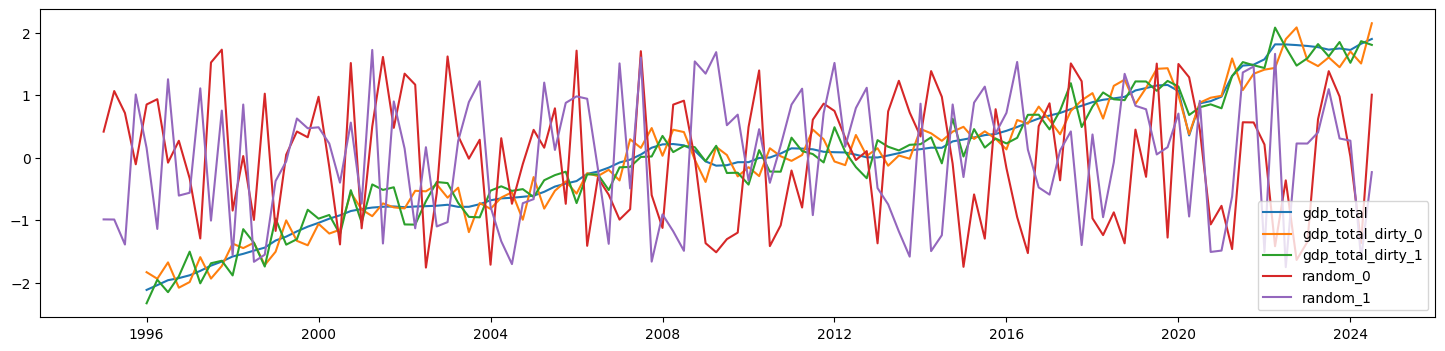

In [6461]:
scaler = StandardScaler()
df1_scaled = scaler.fit_transform(df1)

scaled_features_df = pd.DataFrame(df1_scaled, index=df1.index, columns=df1.columns)
scaled_features_df[['gdp_total','gdp_total_dirty_0','gdp_total_dirty_1', 'random_0', 'random_1']].plot()
scaled_features_df.head()

GDP_MEAN = df1['gdp_total'].mean(); print(GDP_MEAN)
GDP_STD = df1['gdp_total'].std(); print(GDP_STD)

print(scaled_features_df.shape)

In [6406]:
#############################
# Dataframe of column names for storing tests
#############################

STORE_FOR_TESTS = pd.DataFrame(columns=scaled_features_df.columns).T

STORE_FOR_TESTS['Qt_Seasonality'] = np.nan
STORE_FOR_TESTS['Semi_Seasonality'] = np.nan
STORE_FOR_TESTS['Level_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Data'] = 'False'

In [6407]:
def seasonality_test(data):
    kw_test1 = data.iloc[0:100,:]
    kw_test1['Qts'] = [1,2,3,4] * int(len(kw_test1)/4)
    kw_test1['Semi'] = [1,2] * int(len(kw_test1)/2)
    kw_test1.dropna(inplace=True)
    
    return kw_test1

kw1 = seasonality_test(scaled_features_df)

### Deseasonalize if needed (Kruskal-Wallis test)

(119, 21)


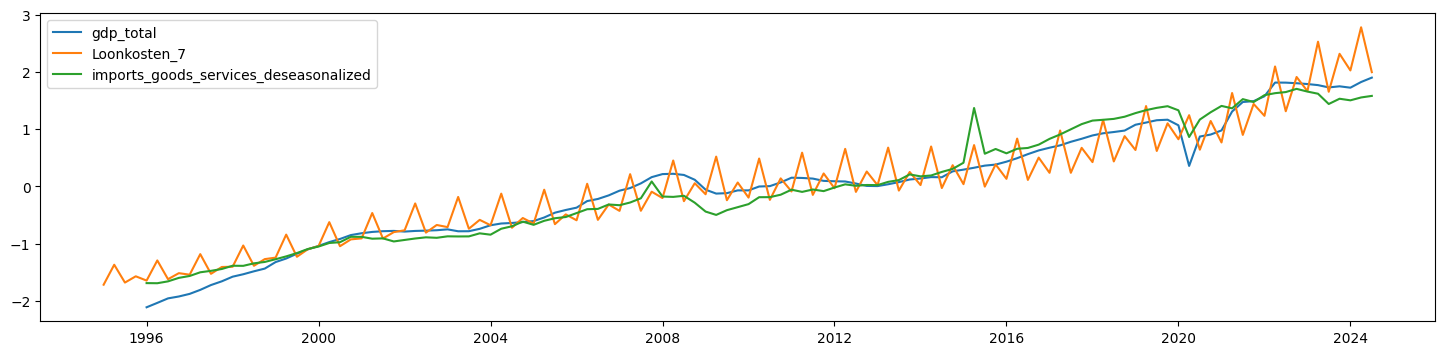

In [6408]:
scaled_features_df[['gdp_total', 'Loonkosten_7', 'imports_goods_services_deseasonalized']].plot()

print(df1.shape)

In [6409]:
def Kruskal_Wallis_Qt(data, STORE_FOR_TESTS): # Quarterly seasonality
    
    for col in data.columns:
        # no need to test these
        if (col == 'Qts' or col == 'Semi'):
            continue
        res = []
        for i in data['Qts'].unique():
            res.append(data[data['Qts'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.50):  #p-value
            STORE_FOR_TESTS.loc[col,'Qt_Seasonality'] = 'No_Qt_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Qt_Seasonality'] = 'Qt_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Qt(kw1, STORE_FOR_TESTS)

In [6410]:
def Kruskal_Wallis_Semi(data, STORE_FOR_TESTS): # Semi yearly
    
    for col in data.columns:
        # no need to test
        if (col == 'Qts' or col == 'Semi'):
            continue
        res = []
        for i in data['Semi'].unique():
            res.append(data[data['Semi'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.50):  #p-value
            STORE_FOR_TESTS.loc[col, 'Semi_Seasonality'] = 'No_Semi_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Semi_Seasonality'] = 'Semi_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Semi(kw1, STORE_FOR_TESTS)

In [6411]:
STORE_FOR_TESTS

,Qt_Seasonality,Semi_Seasonality,Level_Stationary,Difference_Stationary,Difference_Data
gdp_total,No_Qt_Seasonality,No_Semi_Seasonality,NaN,NaN,False
imports_goods_services_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NaN,NaN,False
household_cons_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NaN,NaN,False
gov_consumption_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NaN,NaN,False
investments_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NaN,NaN,False
gpd_invest_business_households_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NaN,NaN,False
gov_invest_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NaN,NaN,False
change_supply_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NaN,NaN,False
exports_goods_services_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NaN,NaN,False
BeloningSeizoengecorrigeerd_2,No_Qt_Seasonality,No_Semi_Seasonality,NaN,NaN,False


In [6412]:
scaled_features_df.dropna(inplace=True)

In [6413]:
# Select feature if contains seasonality (so "No_ not present in name", then deseasonalize)


deseasonalizeThese = STORE_FOR_TESTS[~STORE_FOR_TESTS['Semi_Seasonality'].str.contains("No_")].index

for i in deseasonalizeThese:

    smdt = scaled_features_df[i]

    if any(smdt < 0):
        smdata = sm.tsa.seasonal_decompose(scaled_features_df[i], model='additive', period=4)
        scaled_features_df.loc[:, i] = smdata.trend
    else:
        smdata = sm.tsa.seasonal_decompose(scaled_features_df[i], model='multiplicative', period=4)
        scaled_features_df.loc[:, i] = smdata.trend

scaled_features_df


,gdp_total,imports_goods_services_deseasonalized,household_cons_deseasonalized,gov_consumption_deseasonalized,investments_deseasonalized,gpd_invest_business_households_deseasonalized,gov_invest_deseasonalized,change_supply_deseasonalized,exports_goods_services_deseasonalized,BeloningSeizoengecorrigeerd_2,...,BeloningVanWerknemers_8,Germany_GDP,France_GDP,Italy_GDP,Spain_GDP,Belgium_GDP,gdp_total_dirty_0,gdp_total_dirty_1,random_0,random_1
1996-01-01,-2.113368,-1.691106,-2.705271,-1.858223,-2.026420,-1.786021,-2.801249,0.355972,-1.640590,-1.618999,...,0.217310,-1.848506,NaN,NaN,NaN,NaN,-2.025372,-2.097109,NaN,1.096401
1996-04-01,-2.036599,-1.693240,-2.641594,-1.833356,-1.623077,-1.447322,-2.110295,0.125400,-1.663685,-1.587067,...,-0.016444,-1.696510,NaN,NaN,NaN,NaN,-2.342169,-2.066303,NaN,-1.639120
1996-07-01,-1.957903,-1.660543,-2.524940,-1.811804,-1.565810,-1.386373,-2.074308,0.024707,-1.618697,-1.563666,...,-0.133322,-1.532971,-1.850752,-1.944518,-1.897168,-1.647426,-2.043313,-1.692433,0.209411,-1.778676
1996-10-01,-1.924805,-1.599658,-2.404323,-1.781708,-1.345256,-1.193588,-1.758820,-0.315314,-1.593693,-1.533599,...,-0.289158,-1.387710,-1.822293,-1.921130,-1.863767,-1.603525,-1.720474,-1.815905,0.280129,1.330111
1997-01-01,-1.879208,-1.566295,-2.307883,-1.744471,-1.492137,-1.235988,-2.636907,-0.354715,-1.538806,-1.509964,...,0.762738,-1.794633,-1.777973,-1.850388,-1.822338,-1.553388,-1.775258,-1.654986,0.292225,-1.437560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,1.727624,1.437932,1.690311,1.662752,1.477835,1.461839,0.873042,-0.815130,1.498111,2.133605,...,1.230247,1.436714,1.508952,1.622033,1.507183,1.666897,1.991003,1.894774,0.080531,1.042385
2023-10-01,1.746885,1.529781,1.838407,1.729321,1.324143,1.336960,0.595941,-1.278463,1.589926,2.238911,...,1.308165,1.634885,1.539738,1.640927,1.582985,1.685615,1.953979,1.387930,0.105942,0.800344
2024-01-01,1.722907,1.502018,1.905519,1.733146,1.382803,1.427058,0.406408,-1.355077,1.531504,2.290389,...,1.285438,1.489624,1.570972,1.652032,1.666659,1.736502,1.392560,1.444394,0.457333,0.121639
2024-04-01,1.822122,1.552263,1.803133,1.815910,1.439760,1.430205,0.828658,-0.698384,1.608355,2.339589,...,1.292067,1.346287,NaN,NaN,NaN,NaN,1.783295,1.969543,NaN,0.992828


[ 0  1  2  7 16 17]
['imports_goods_services_deseasonalized', 'household_cons_deseasonalized', 'gov_consumption_deseasonalized', 'exports_goods_services_deseasonalized', 'gdp_total_dirty_0', 'gdp_total_dirty_1']


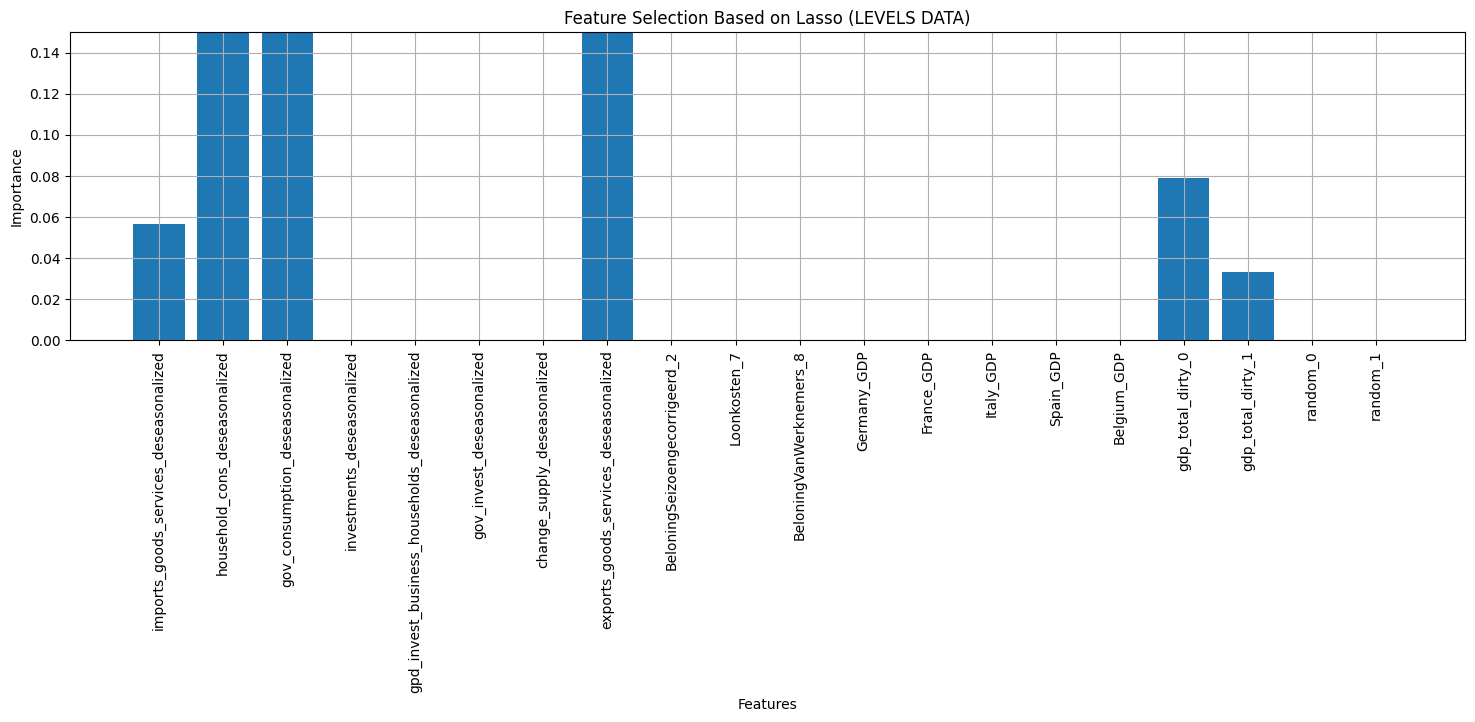

(115, 21)


In [6414]:
def lassoreg(data, alpha=0.0001, title='Feature Selection Based on Lasso'):

    myalpha = alpha
    data1 = data.copy()
    data1 = data1.dropna()

    Xcolnames =  data1.iloc[:, 1:]

    Y = data1.iloc[:, 0].values
    X = data1.iloc[:, 1:].values

    ### assertions
    # does X contain gdptotal, it should not
    assert X.shape[1] == data.shape[1] - 1

    # does X contain gdptotal, it should not
    val = 'gdp_total'
    lst = Xcolnames.columns
    assert val not in lst

    # regression
    lasso = Lasso(alpha = myalpha, fit_intercept=False, max_iter=10000)
    
    lasso.fit(X,Y)

    selected_features_lasso = np.flatnonzero(lasso.coef_)
    print(selected_features_lasso)

    best_variables = [Xcolnames.columns[i] for i in selected_features_lasso]
    print(best_variables)


    # calling the model with the best parameter
    lasso1 = Lasso(alpha=myalpha)
    lasso1.fit(X, Y)

    # Using np.abs() to make coefficients positive.  
    lasso1_coef = np.abs(lasso1.coef_)

    # plotting the Column Names and Importance of Columns. 
    plt.bar(lst, lasso1_coef)
    plt.xticks(rotation=90)
    plt.grid()
    plt.title(title)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.ylim(0, 0.15)
    plt.show()

    return best_variables

lassoreg(scaled_features_df, alpha=0.1, title='Feature Selection Based on Lasso (LEVELS DATA)')

print(scaled_features_df.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
['imports_goods_services_deseasonalized', 'household_cons_deseasonalized', 'gov_consumption_deseasonalized', 'investments_deseasonalized', 'gpd_invest_business_households_deseasonalized', 'gov_invest_deseasonalized', 'change_supply_deseasonalized', 'exports_goods_services_deseasonalized', 'BeloningSeizoengecorrigeerd_2', 'Loonkosten_7', 'BeloningVanWerknemers_8', 'Germany_GDP', 'France_GDP', 'Italy_GDP', 'Spain_GDP', 'Belgium_GDP', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'random_1']


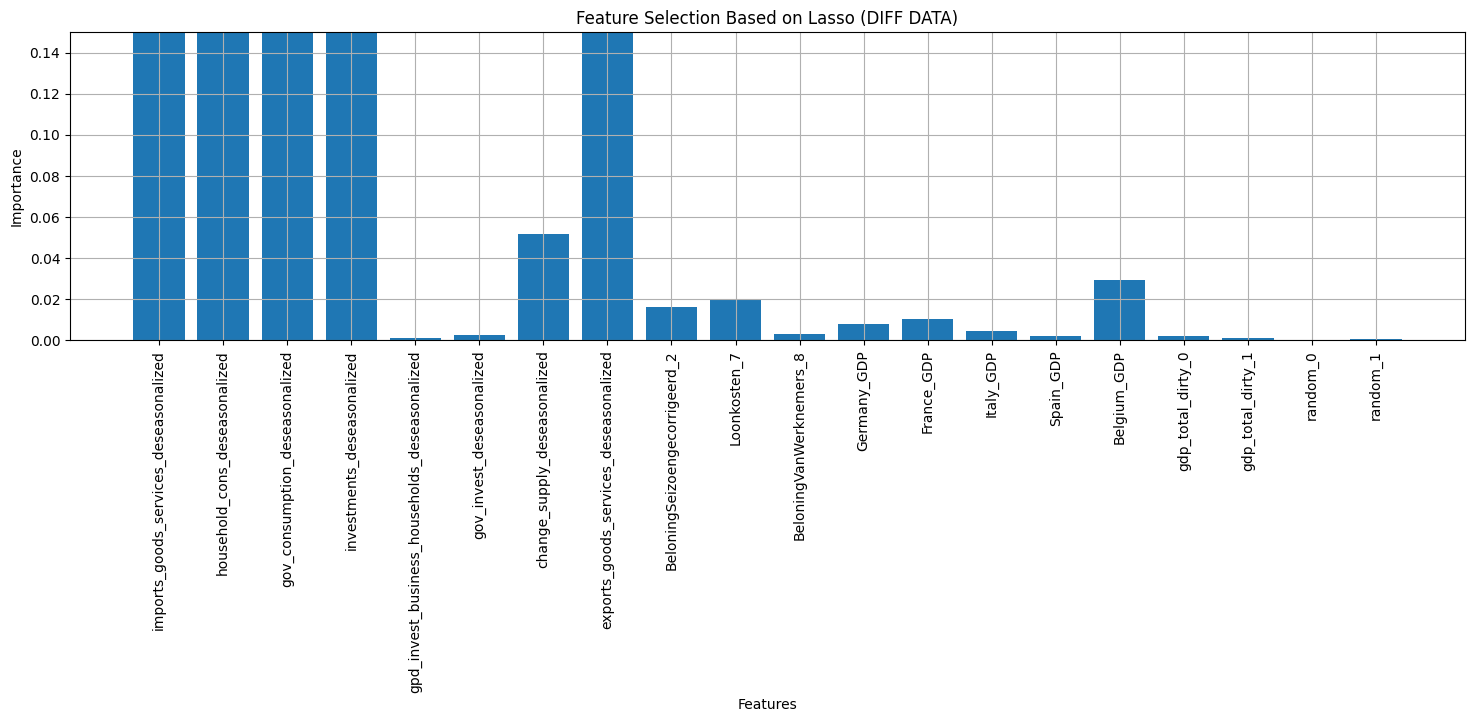

['imports_goods_services_deseasonalized',
 'household_cons_deseasonalized',
 'gov_consumption_deseasonalized',
 'investments_deseasonalized',
 'gpd_invest_business_households_deseasonalized',
 'gov_invest_deseasonalized',
 'change_supply_deseasonalized',
 'exports_goods_services_deseasonalized',
 'BeloningSeizoengecorrigeerd_2',
 'Loonkosten_7',
 'BeloningVanWerknemers_8',
 'Germany_GDP',
 'France_GDP',
 'Italy_GDP',
 'Spain_GDP',
 'Belgium_GDP',
 'gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_0',
 'random_1']

In [6415]:
lassoreg(scaled_features_df.diff().dropna(), alpha=0.0, title='Feature Selection Based on Lasso (DIFF DATA)') 

In [6416]:
df1 = scaled_features_df.copy()
number_lags = 1

df = df1.iloc[:,:]

for lag in range(1, number_lags+1):
    for col in df.columns:
        df[col + '_lag_' + str(lag)] = df[col].shift(lag)
    
selectThese = [col for col in df.columns if '_lag_' in col]
selectThese = ['gdp_total', 'gdp_total_dirty_0', 'gdp_total_dirty_1','random_0', 'random_1'] + selectThese 
df_lag = df[selectThese]

print(df_lag.shape)


(115, 26)


[ 0  1  4  8 11 12 13 15 17 18 19 20 21 22]
['gdp_total_dirty_0', 'gdp_total_dirty_1', 'gdp_total_lag_1', 'investments_deseasonalized_lag_1', 'change_supply_deseasonalized_lag_1', 'exports_goods_services_deseasonalized_lag_1', 'BeloningSeizoengecorrigeerd_2_lag_1', 'BeloningVanWerknemers_8_lag_1', 'France_GDP_lag_1', 'Italy_GDP_lag_1', 'Spain_GDP_lag_1', 'Belgium_GDP_lag_1', 'gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1']


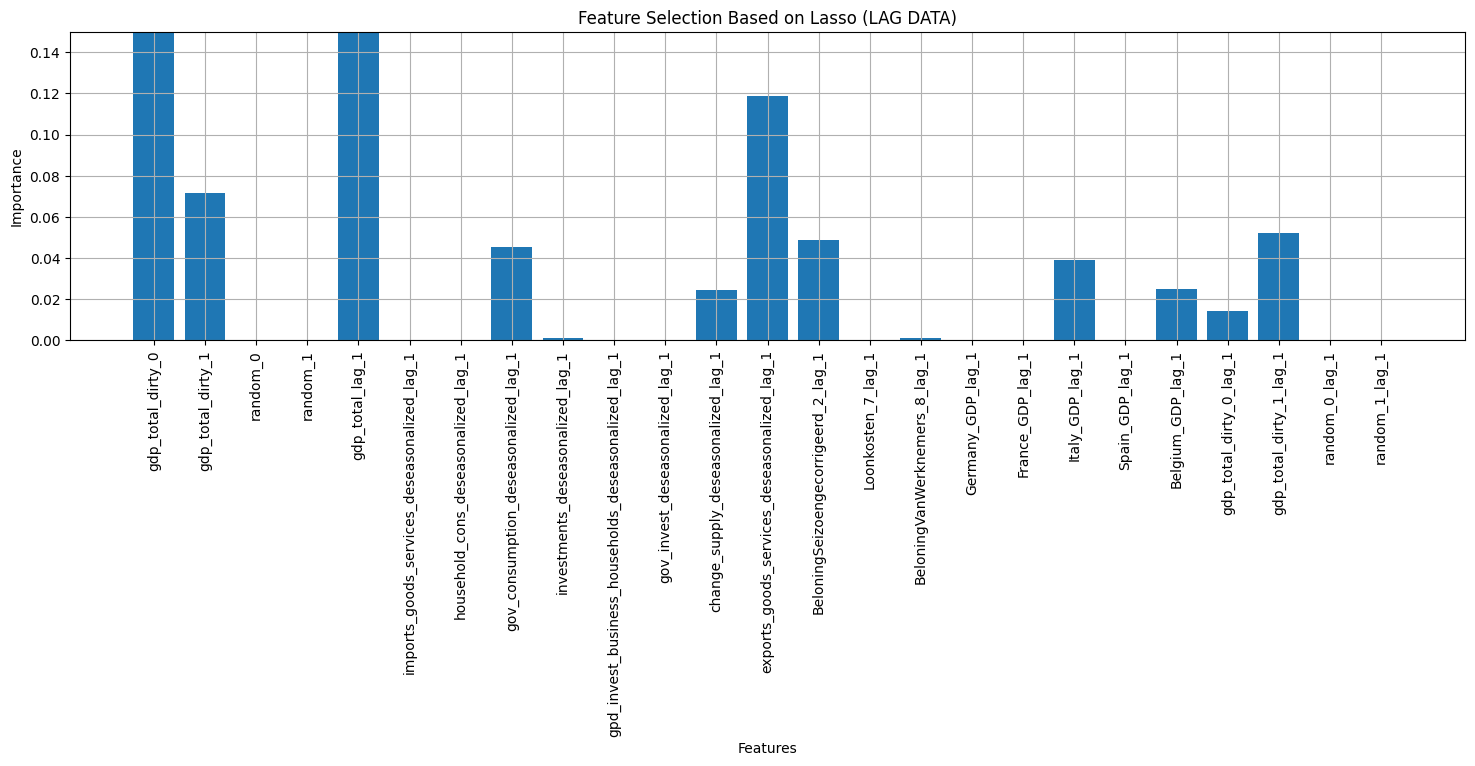

['gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'gdp_total_lag_1',
 'investments_deseasonalized_lag_1',
 'change_supply_deseasonalized_lag_1',
 'exports_goods_services_deseasonalized_lag_1',
 'BeloningSeizoengecorrigeerd_2_lag_1',
 'BeloningVanWerknemers_8_lag_1',
 'France_GDP_lag_1',
 'Italy_GDP_lag_1',
 'Spain_GDP_lag_1',
 'Belgium_GDP_lag_1',
 'gdp_total_dirty_0_lag_1',
 'gdp_total_dirty_1_lag_1']

In [6417]:
lassoreg(df_lag, alpha=0.01, title='Feature Selection Based on Lasso (LAG DATA)') 

[ 0  1  2  3  6  8 10 11 16 17 18 21 22]
['gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'random_1', 'household_cons_deseasonalized_lag_1', 'investments_deseasonalized_lag_1', 'gov_invest_deseasonalized_lag_1', 'change_supply_deseasonalized_lag_1', 'Germany_GDP_lag_1', 'France_GDP_lag_1', 'Italy_GDP_lag_1', 'gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1']


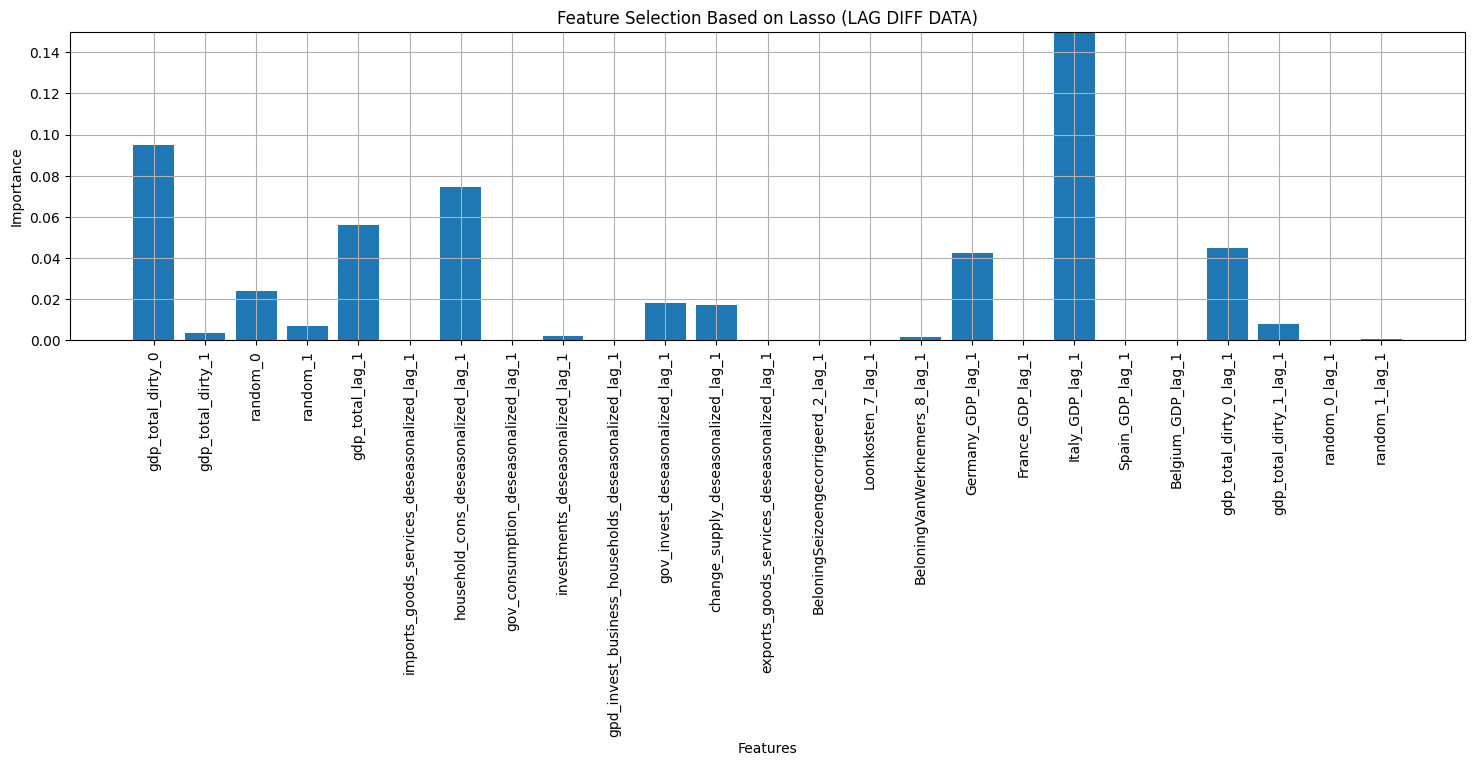

['gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_0',
 'random_1',
 'household_cons_deseasonalized_lag_1',
 'investments_deseasonalized_lag_1',
 'gov_invest_deseasonalized_lag_1',
 'change_supply_deseasonalized_lag_1',
 'Germany_GDP_lag_1',
 'France_GDP_lag_1',
 'Italy_GDP_lag_1',
 'gdp_total_dirty_0_lag_1',
 'gdp_total_dirty_1_lag_1']

In [6418]:
lassoreg(df_lag.diff().dropna(), alpha=0.001, title='Feature Selection Based on Lasso (LAG DIFF DATA)') 


### Make sure data is stationary

In [6419]:

# adf test, if critical value is greater than test statistic, then the series is not stationary

def adf_test(timeseries, verbose=False):
    if verbose:
        print ('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    
    if verbose:
        print (dfoutput)
        print(dftest)

    if dftest[0] > dftest[4]['5%']:
        if verbose:
            print('ADF: Time Series is not Stationary')
       
        return "NotStationary"
    else:
        if verbose:    
            print('ADF: Time Series is Stationary') 
        return "Stationary" 


# adf_test(timeseries, verbose=True)   


In [6420]:

def kpss_test(timeseries, verbose=False):

    if verbose:
        print ('Results of KPSS Test:')

    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    
    if verbose:
        print (kpss_output)
        print(kpsstest[0])
        print(kpsstest[3])

    if kpsstest[0] > kpsstest[3]['5%']:
        if verbose:
            print('KPSS: Time Series is not Stationary')
        return "NotStationary"
    else: 
        if verbose:   
            print('KPSS: Time Series is Stationary')
        return "Stationary"

# kpss_test(timeseries, verbose=True) 

### Loop through KPSS and ADF tests, mark those series that need to be differenced

In [6421]:
def stationdarydf(mydata, STORE_FOR_TESTS, form='Levels', save=False):

    stationary_features = []
    seriesLength = []

    for col in mydata.columns:

        timeseries = mydata[col].dropna()
        seriesLength.append(len(timeseries))

        adf1 = adf_test(timeseries, verbose=False)
        kpss1 = kpss_test(timeseries, verbose=False)
        if adf1 == "Stationary" and kpss1 == "Stationary":
            stationary_features.append('Stationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'Stationary'
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'Stationary'
        else:
            stationary_features.append('NotStationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'NotStationary' 
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'NotStationary'
        
    df = pd.DataFrame(data = [mydata.columns, stationary_features, seriesLength]).T
    df.columns = ['Feature', 'Stationary', 'Length']    

    if save:
        df.to_csv(outputdata1 + "startionarity.csv")

    return df, STORE_FOR_TESTS

form = 'Levels'
df, STORE_FOR_TESTS = stationdarydf(scaled_features_df, STORE_FOR_TESTS, form, save=False)

print(df.shape)


(21, 3)


### If not stationary, difference, then test for stationarity again

In [6422]:

def differenceData(originalData, STORE_FOR_TESTS, mydiff=1):

    ## which features are not stationary
    # function from above
    stat1, _ = stationdarydf(originalData, STORE_FOR_TESTS, form, save=False)
    # collect
    stat2 = stat1[stat1['Stationary'].str.contains('NotStationary')]
    notstationary = stat2['Feature'].tolist()

    # dont change orginal data
    stationarydf_diff = originalData.copy()

    # selectively difference the data
    for i in notstationary:
        stationarydf_diff[i] = stationarydf_diff[i].diff(mydiff)

    # rename columns
    for col in notstationary:
        STORE_FOR_TESTS.loc[col, "Difference_Data"] = "True"
    
    scaled_features_df_diff = stationarydf_diff.copy()

    return scaled_features_df_diff, STORE_FOR_TESTS

scaled_features_df_diff, STORE_FOR_TESTS = differenceData(scaled_features_df, STORE_FOR_TESTS, mydiff=1)

print(scaled_features_df_diff.shape)


(115, 21)


In [6423]:

form = 'Differenced'
df1, STORE_FOR_TESTS = stationdarydf(scaled_features_df_diff, STORE_FOR_TESTS, form, save = 'False')

<Axes: >

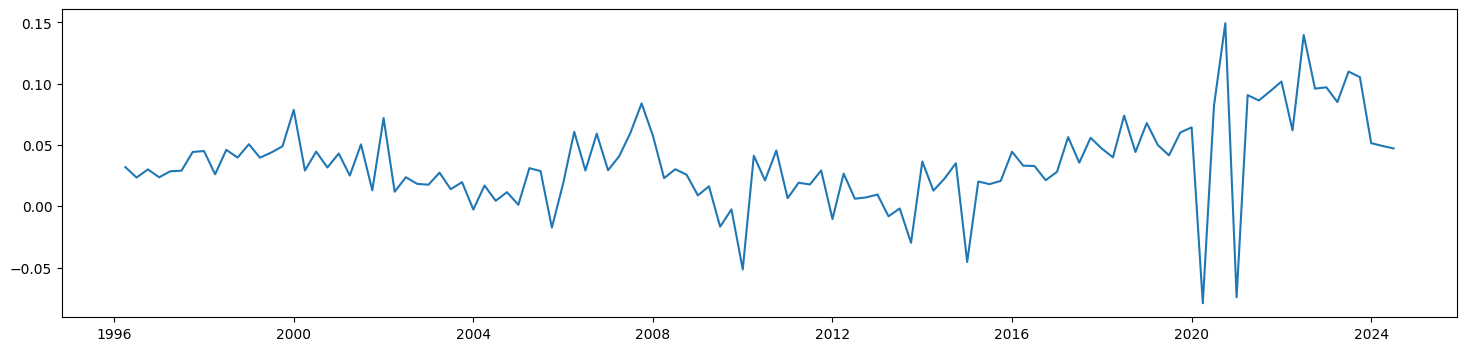

In [6424]:
scaled_features_df_diff['BeloningSeizoengecorrigeerd_2'].plot()

[ 1  2  3  4  6  7 10 11 13 16 17 19]
['household_cons_deseasonalized', 'gov_consumption_deseasonalized', 'investments_deseasonalized', 'gpd_invest_business_households_deseasonalized', 'change_supply_deseasonalized', 'exports_goods_services_deseasonalized', 'BeloningVanWerknemers_8', 'Germany_GDP', 'Italy_GDP', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_1']


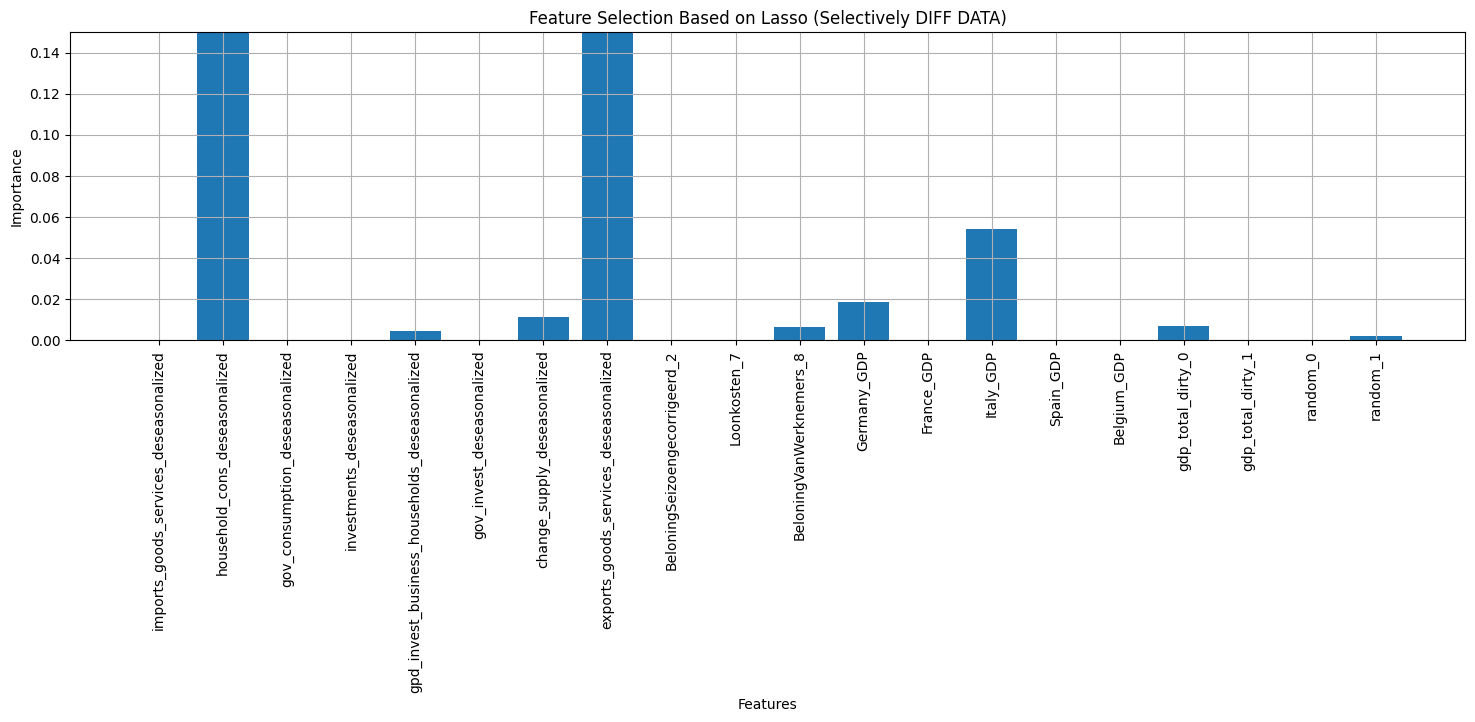

['household_cons_deseasonalized',
 'gov_consumption_deseasonalized',
 'investments_deseasonalized',
 'gpd_invest_business_households_deseasonalized',
 'change_supply_deseasonalized',
 'exports_goods_services_deseasonalized',
 'BeloningVanWerknemers_8',
 'Germany_GDP',
 'Italy_GDP',
 'gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_1']

In [6425]:
lassoreg(scaled_features_df_diff.dropna(), alpha=0.001, title='Feature Selection Based on Lasso (Selectively DIFF DATA)') 

(115, 21)


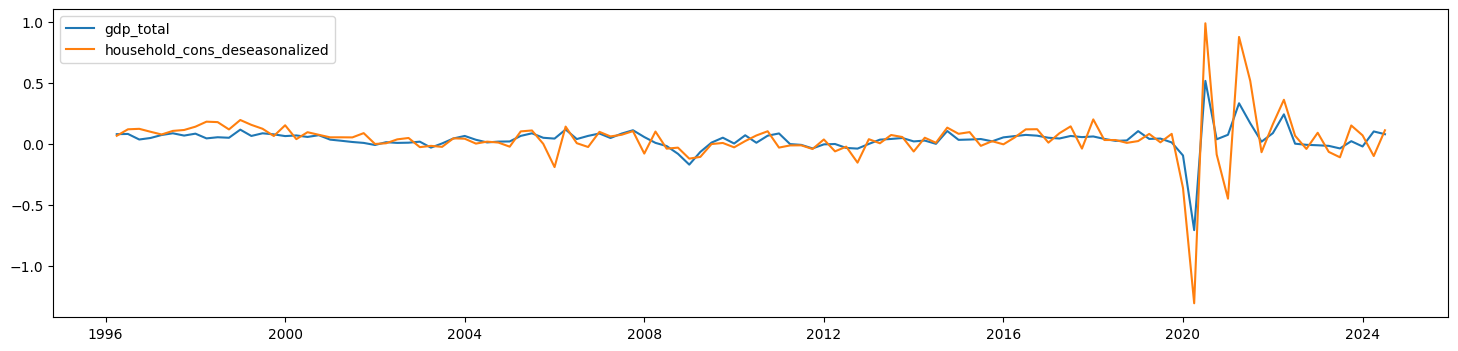

In [6426]:
scaled_features_df_diff[['gdp_total', 'household_cons_deseasonalized']].plot()
scaled_features_df_diff.columns

print(scaled_features_df_diff.shape)

In [6427]:
df = scaled_features_df_diff.copy()
number_lags = 1

for lag in range(1, number_lags+1):
    for col in df.columns:
        df[col + '_lag_' + str(lag)] = df[col].shift(lag)
    
selectThese = [col for col in df.columns if '_lag_' in col]
df_lag = df[selectThese]

scaled_features_df_diff_lag = scaled_features_df_diff.merge(df_lag, left_index=True, right_index=True)

print(scaled_features_df_diff_lag.shape)


(115, 42)


In [6428]:
### Select if lagged 

chooseThese = ['gdp_total'] + [x for x in scaled_features_df_diff_lag.columns if '_lag' in x]
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag[chooseThese]

scaled_features_df_diff_lag_subset

,gdp_total,gdp_total_lag_1,imports_goods_services_deseasonalized_lag_1,household_cons_deseasonalized_lag_1,gov_consumption_deseasonalized_lag_1,investments_deseasonalized_lag_1,gpd_invest_business_households_deseasonalized_lag_1,gov_invest_deseasonalized_lag_1,change_supply_deseasonalized_lag_1,exports_goods_services_deseasonalized_lag_1,...,BeloningVanWerknemers_8_lag_1,Germany_GDP_lag_1,France_GDP_lag_1,Italy_GDP_lag_1,Spain_GDP_lag_1,Belgium_GDP_lag_1,gdp_total_dirty_0_lag_1,gdp_total_dirty_1_lag_1,random_0_lag_1,random_1_lag_1
1996-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-04-01,0.076770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.096401
1996-07-01,0.078696,0.076770,-0.002134,0.063677,0.024867,0.403343,0.338698,0.690954,-0.230572,-0.023095,...,-0.233755,0.151995,NaN,NaN,NaN,NaN,-0.316798,0.030805,NaN,-1.639120
1996-10-01,0.033098,0.078696,0.032696,0.116654,0.021552,0.057267,0.060949,0.035987,-0.100693,0.044988,...,-0.116877,0.163540,NaN,NaN,NaN,NaN,0.298857,0.373870,NaN,-1.778676
1997-01-01,0.045598,0.033098,0.060886,0.120617,0.030096,0.220554,0.192785,0.315488,-0.340021,0.025004,...,-0.155836,0.145261,0.028459,0.023388,0.033401,0.043901,0.322838,-0.123472,0.070718,1.330111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,-0.040055,-0.018947,-0.037523,-0.068433,0.031499,-0.119022,-0.097552,-0.214723,1.791311,-0.078359,...,-0.038959,-0.253004,0.029660,0.000869,0.046728,0.009025,0.230243,-0.209071,-0.426662,1.116714
2023-10-01,0.019261,-0.040055,-0.179403,-0.112690,0.134794,-0.132951,-0.191625,0.338279,-1.533741,-0.120684,...,-0.272714,0.166424,0.040427,0.001586,0.059509,0.011894,0.258745,0.435592,-0.259109,1.042385
2024-01-01,-0.023978,0.019261,0.091849,0.148096,0.066568,-0.153691,-0.124879,-0.277101,-0.463333,0.091815,...,0.077918,0.198171,0.030787,0.018894,0.075803,0.018718,-0.037023,-0.506844,0.025411,0.800344
2024-04-01,0.099215,-0.023978,-0.027763,0.067112,0.003826,0.058660,0.090099,-0.189532,-0.076614,-0.058421,...,-0.022727,-0.145261,0.031233,0.011105,0.083673,0.050887,-0.561419,0.056464,0.351391,0.121639


In [6429]:
### Remove 'sure' data

removeThese = ['gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'random_0_lag_1', 'random_1_lag_1']
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag_subset.loc[:, ~scaled_features_df_diff_lag_subset.columns.isin(removeThese)]

print(scaled_features_df_diff_lag_subset.shape)

(115, 18)


In [6430]:
scaled_features_df_diff_lag

,gdp_total,imports_goods_services_deseasonalized,household_cons_deseasonalized,gov_consumption_deseasonalized,investments_deseasonalized,gpd_invest_business_households_deseasonalized,gov_invest_deseasonalized,change_supply_deseasonalized,exports_goods_services_deseasonalized,BeloningSeizoengecorrigeerd_2,...,BeloningVanWerknemers_8_lag_1,Germany_GDP_lag_1,France_GDP_lag_1,Italy_GDP_lag_1,Spain_GDP_lag_1,Belgium_GDP_lag_1,gdp_total_dirty_0_lag_1,gdp_total_dirty_1_lag_1,random_0_lag_1,random_1_lag_1
1996-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-04-01,0.076770,-0.002134,0.063677,0.024867,0.403343,0.338698,0.690954,-0.230572,-0.023095,0.031932,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.096401
1996-07-01,0.078696,0.032696,0.116654,0.021552,0.057267,0.060949,0.035987,-0.100693,0.044988,0.023401,...,-0.233755,0.151995,NaN,NaN,NaN,NaN,-0.316798,0.030805,NaN,-1.639120
1996-10-01,0.033098,0.060886,0.120617,0.030096,0.220554,0.192785,0.315488,-0.340021,0.025004,0.030067,...,-0.116877,0.163540,NaN,NaN,NaN,NaN,0.298857,0.373870,NaN,-1.778676
1997-01-01,0.045598,0.033363,0.096441,0.037237,-0.146881,-0.042399,-0.878087,-0.039402,0.054886,0.023634,...,-0.155836,0.145261,0.028459,0.023388,0.033401,0.043901,0.322838,-0.123472,0.070718,1.330111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,-0.040055,-0.179403,-0.112690,0.134794,-0.132951,-0.191625,0.338279,-1.533741,-0.120684,0.109828,...,-0.038959,-0.253004,0.029660,0.000869,0.046728,0.009025,0.230243,-0.209071,-0.426662,1.116714
2023-10-01,0.019261,0.091849,0.148096,0.066568,-0.153691,-0.124879,-0.277101,-0.463333,0.091815,0.105306,...,-0.272714,0.166424,0.040427,0.001586,0.059509,0.011894,0.258745,0.435592,-0.259109,1.042385
2024-01-01,-0.023978,-0.027763,0.067112,0.003826,0.058660,0.090099,-0.189532,-0.076614,-0.058421,0.051479,...,0.077918,0.198171,0.030787,0.018894,0.075803,0.018718,-0.037023,-0.506844,0.025411,0.800344
2024-04-01,0.099215,0.050245,-0.102386,0.082764,0.056957,0.003147,0.422250,0.656692,0.076850,0.049200,...,-0.022727,-0.145261,0.031233,0.011105,0.083673,0.050887,-0.561419,0.056464,0.351391,0.121639


[ 2  6  7 12 14]
['household_cons_deseasonalized_lag_1', 'gov_invest_deseasonalized_lag_1', 'change_supply_deseasonalized_lag_1', 'Germany_GDP_lag_1', 'Italy_GDP_lag_1']


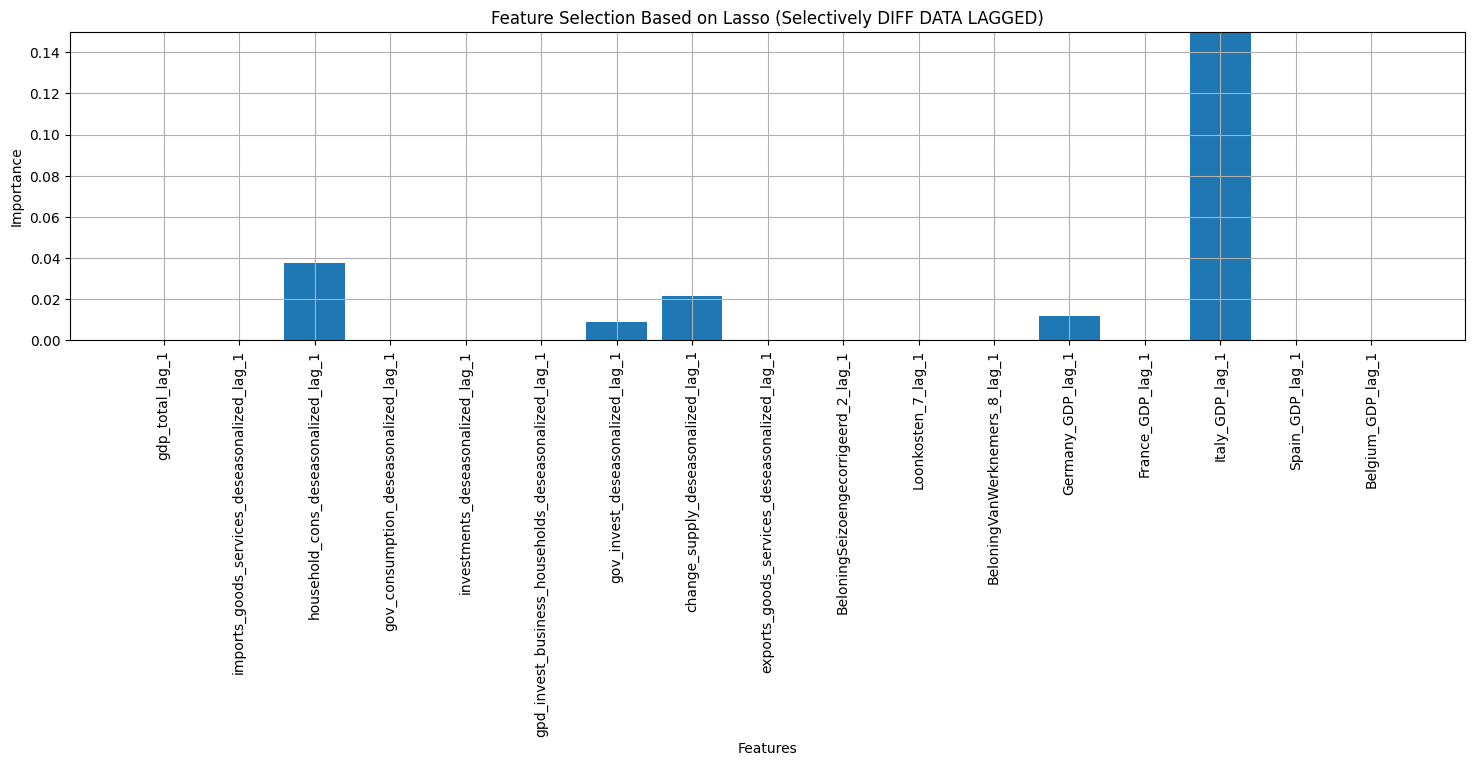

In [6431]:
lasout = lassoreg(scaled_features_df_diff_lag_subset.dropna(), alpha=0.002, title='Feature Selection Based on Lasso (Selectively DIFF DATA LAGGED)') 

In [6432]:
lasout1 = ['gdp_total'] + lasout

reg1 = scaled_features_df_diff_lag[lasout1]
#reg1 = scaled_features_df_diff_lag[['gdp_total', 'investments_lag_1', 'household_cons_deseasonalized_lag_1', 'gov_invest_deseasonalized_lag_1', 'Italy_GDP_lag_1']]
reg1.to_csv("tmp.csv")
#reg1 = scaled_features_df_diff_lag[['random_0_lag_1', 'random_1_lag_1']]
reg1.dropna(inplace=True)

########################
test_train_split = 109
########################

X = reg1.iloc[0:test_train_split, 1:]
X = sm.add_constant(X)

y_true = reg1.iloc[0:test_train_split:, 0]

model = sm.OLS(y_true,X)
results = model.fit()
print(results.summary())


print(scaled_features_df_diff_lag.shape)
scaled_features_df_diff_lag

                            OLS Regression Results                            
Dep. Variable:              gdp_total   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     14.52
Date:                Wed, 04 Dec 2024   Prob (F-statistic):           9.32e-11
Time:                        17:48:58   Log-Likelihood:                 122.62
No. Observations:                 109   AIC:                            -233.2
Df Residuals:                     103   BIC:                            -217.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

,gdp_total,imports_goods_services_deseasonalized,household_cons_deseasonalized,gov_consumption_deseasonalized,investments_deseasonalized,gpd_invest_business_households_deseasonalized,gov_invest_deseasonalized,change_supply_deseasonalized,exports_goods_services_deseasonalized,BeloningSeizoengecorrigeerd_2,...,BeloningVanWerknemers_8_lag_1,Germany_GDP_lag_1,France_GDP_lag_1,Italy_GDP_lag_1,Spain_GDP_lag_1,Belgium_GDP_lag_1,gdp_total_dirty_0_lag_1,gdp_total_dirty_1_lag_1,random_0_lag_1,random_1_lag_1
1996-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-04-01,0.076770,-0.002134,0.063677,0.024867,0.403343,0.338698,0.690954,-0.230572,-0.023095,0.031932,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.096401
1996-07-01,0.078696,0.032696,0.116654,0.021552,0.057267,0.060949,0.035987,-0.100693,0.044988,0.023401,...,-0.233755,0.151995,NaN,NaN,NaN,NaN,-0.316798,0.030805,NaN,-1.639120
1996-10-01,0.033098,0.060886,0.120617,0.030096,0.220554,0.192785,0.315488,-0.340021,0.025004,0.030067,...,-0.116877,0.163540,NaN,NaN,NaN,NaN,0.298857,0.373870,NaN,-1.778676
1997-01-01,0.045598,0.033363,0.096441,0.037237,-0.146881,-0.042399,-0.878087,-0.039402,0.054886,0.023634,...,-0.155836,0.145261,0.028459,0.023388,0.033401,0.043901,0.322838,-0.123472,0.070718,1.330111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,-0.040055,-0.179403,-0.112690,0.134794,-0.132951,-0.191625,0.338279,-1.533741,-0.120684,0.109828,...,-0.038959,-0.253004,0.029660,0.000869,0.046728,0.009025,0.230243,-0.209071,-0.426662,1.116714
2023-10-01,0.019261,0.091849,0.148096,0.066568,-0.153691,-0.124879,-0.277101,-0.463333,0.091815,0.105306,...,-0.272714,0.166424,0.040427,0.001586,0.059509,0.011894,0.258745,0.435592,-0.259109,1.042385
2024-01-01,-0.023978,-0.027763,0.067112,0.003826,0.058660,0.090099,-0.189532,-0.076614,-0.058421,0.051479,...,0.077918,0.198171,0.030787,0.018894,0.075803,0.018718,-0.037023,-0.506844,0.025411,0.800344
2024-04-01,0.099215,0.050245,-0.102386,0.082764,0.056957,0.003147,0.422250,0.656692,0.076850,0.049200,...,-0.022727,-0.145261,0.031233,0.011105,0.083673,0.050887,-0.561419,0.056464,0.351391,0.121639


<Axes: >

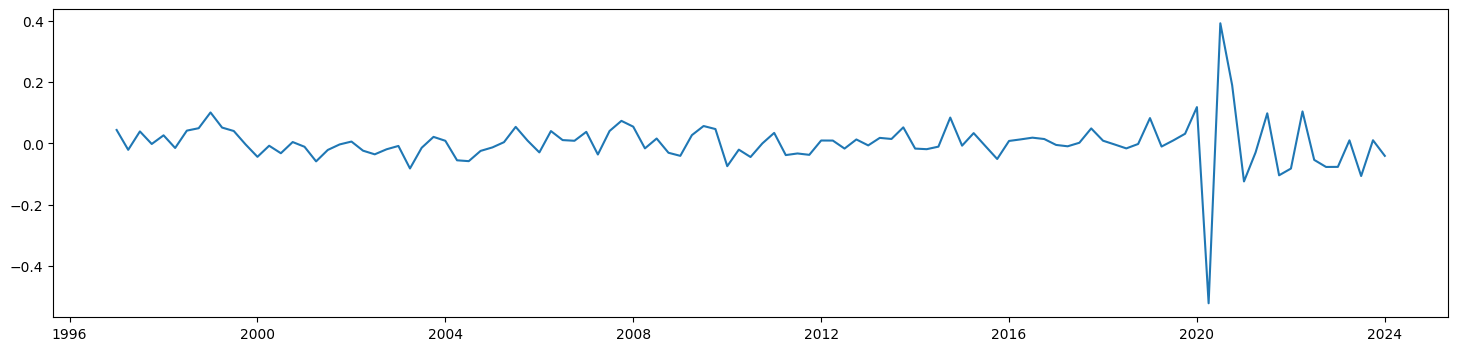

In [6433]:
results.resid.plot()

In [6434]:
ypred = results.predict(X)
Xnew = reg1.iloc[test_train_split:, 1:]
Xnew[['const']] = 1

In [6435]:
reg1.iloc[test_train_split:, 0]

2024-04-01    0.099215
Name: gdp_total, dtype: float64

                real  predicted
2024-04-01  0.099215   0.469055


<Axes: >

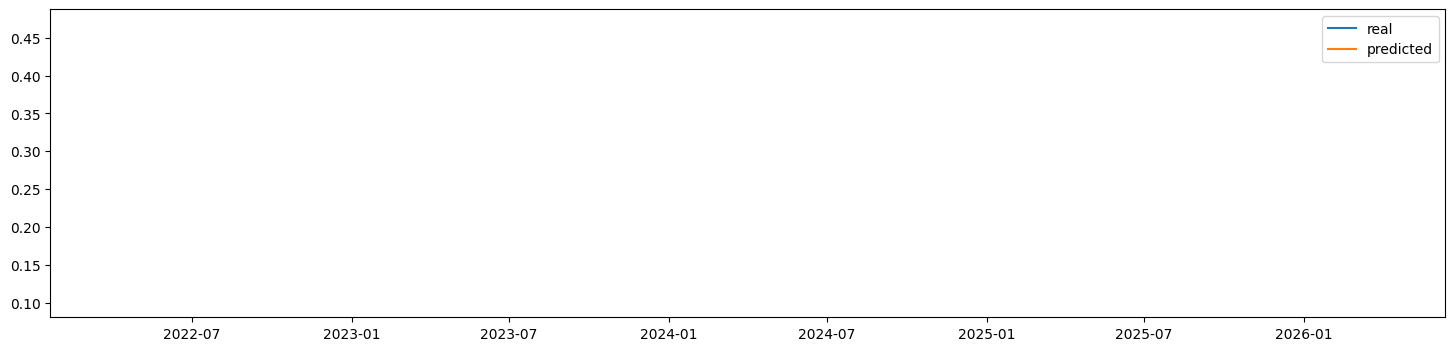

In [6436]:

ynewpred = results.predict(Xnew)  # predict out of sample

# plot real and predicted values
df_pred = pd.DataFrame({'real': reg1.iloc[test_train_split:, 0], 'predicted': ynewpred})
print(df_pred)
df_pred.plot()

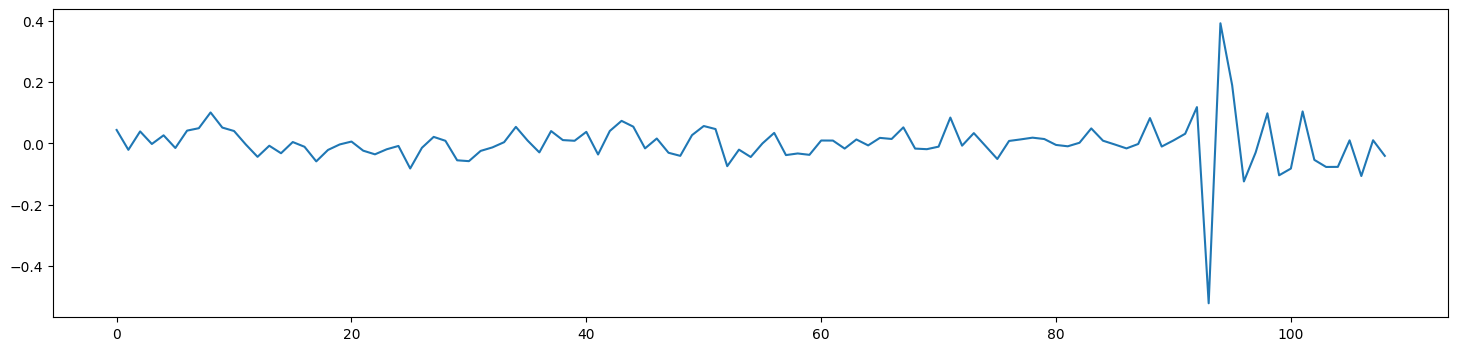

In [6437]:
plt.plot(np.arange(0,(len(results.resid))), results.resid)

### Remove Covid for tests

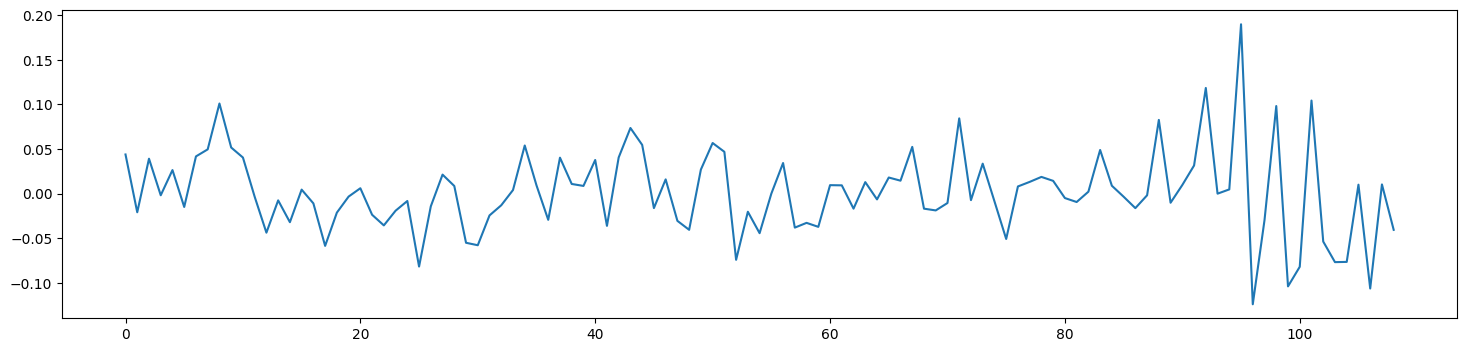

In [6438]:
results.resid[results.resid < -0.4] = np.mean(results.resid)
results.resid[results.resid > 0.2] = np.mean(results.resid)
plt.plot(np.arange(0,(len(results.resid))), results.resid)

### Homoskedasticty

In [6439]:
homoske = sm.stats.diagnostic.het_breuschpagan(results.resid, X)
if homoske[1] < 0.10:
    print('Heteroskedasticity (Breusch-Pagan)')
else:
    print('Homoskedasticity (Breusch-Pagan)')

Heteroskedasticity (Breusch-Pagan)


In [6440]:
# Null hypothesis is homoscedastic and correctly specified.

homoske = sm.stats.diagnostic.het_white(results.resid, X)

if homoske[1] < 0.10:
    print('Heteroskedasticity (White)')
else:
    print('Homoskedasticity (White)')

Heteroskedasticity (White)


### Collinearity

In [6441]:
def dw_test(resids):

    dw1 = sm.stats.stattools.durbin_watson(resids, axis=0)
    print(dw1)

    if dw1 > 2.0:
        if (4 - dw1) < 1.8: 
            print("Negative autoceorrelation is significant")
        else:
            print("Negative autocorrelation is not significant")
    else:
        if dw1 < 1.8:
            print("Positive autocorrelation is significant")
        else:
            print("Positive autocorrelation is not significant")

dw_test(results.resid)

1.9900683654763918
Positive autocorrelation is not significant


### Normality

Residuals are not normally distributed


(array([ 8., 49., 44.,  7.,  1.]),
 array([-0.12395468, -0.06119964,  0.0015554 ,  0.06431045,  0.12706549,
         0.18982053]),
 <BarContainer object of 5 artists>)

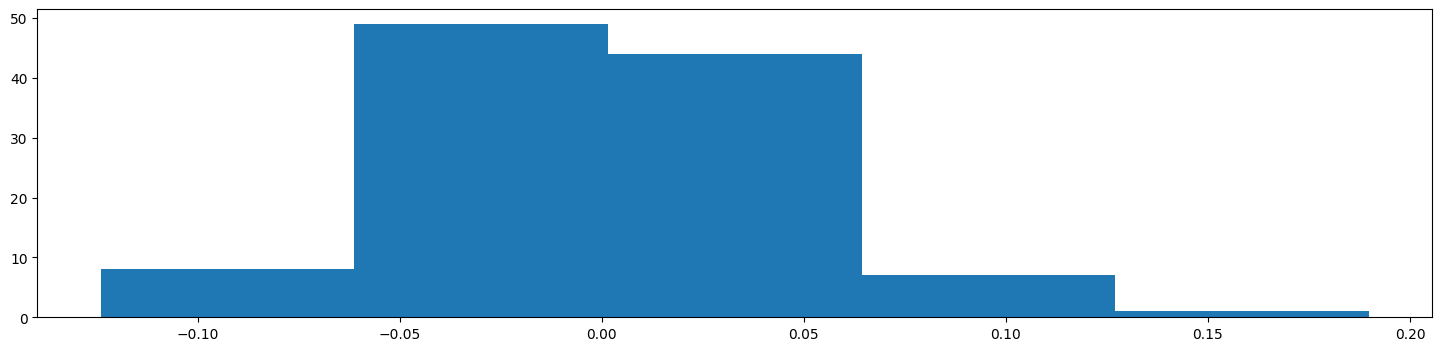

In [6442]:
def normality_test(resids):

    _, p = sm.stats.diagnostic.kstest_normal(resids)

    if p < 0.05:
        print("Residuals are not normally distributed")
    else:
        print("Residuals are normally distributed")


normality_test(results.resid)

plt.hist(results.resid, bins=5)

In [6443]:
STORE_FOR_TESTS

,Qt_Seasonality,Semi_Seasonality,Level_Stationary,Difference_Stationary,Difference_Data
gdp_total,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
imports_goods_services_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
household_cons_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
gov_consumption_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
investments_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
gpd_invest_business_households_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
gov_invest_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
change_supply_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
exports_goods_services_deseasonalized,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,Stationary,True
BeloningSeizoengecorrigeerd_2,No_Qt_Seasonality,No_Semi_Seasonality,NotStationary,NotStationary,True
